In [23]:
from itertools import product
import tqdm
import time
import editdistance 
import matplotlib.pyplot as plt
import random

import pandas as pd
import numpy as np
import numba as nb
from numba import njit, jit, prange, cuda, objmode
from numba.typed import List
from numba.experimental import jitclass
import plotly.graph_objects as go
import random
from collections import defaultdict
from tqdm import tqdm
np.random.seed(0)
random.seed(0)

In [21]:
@njit(fastmath=True)
def l2_dist(a, b): 
    d = a-b
    return np.sum(d*d);


@njit(fastmath=True)
def hamming_distance(a, b):
    return np.sum(a != b);


# only works for k<=32, would overflow otherwise 
@njit(fastmath=True)
def extract_kmers(seq,k):
    kmer = 0
    kmers = np.zeros(len(seq)-k+1,dtype=np.int64)
    for i,c in enumerate(seq):
        kmer = kmer * 4 + c
        kmer = kmer % (4**k)
        if i>=k:
            kmers[i-k] = kmer
    return kmers

@jitclass([
    ('A', nb.int32),
    ('t', nb.int32),
    ('D', nb.int32),
    ('normalize', nb.bool_),
    ('hashes', nb.int32[:, :]),
    ('signs', nb.float32[:, :])])
class TS():
    def __init__(self, t, D, A, normalize = True):
        self.A = A
        self.t = t
        self.D = D
        self.normalize = normalize

        # An A*t array of random integers in [0, D)
        self.hashes = np.empty((self.A, self.t), dtype=np.int32)
        # An A*t array of random +-1
        self.signs = np.empty((self.A, self.t), dtype=np.float32)
        for c in range(self.A):
            for k in range(self.t):
                self.hashes[c][k] = random.randrange(0, self.D)
                self.signs[c][k] = random.randrange(-1, 2, 2)

    def _full_sketch(self, seq: nb.int32[:]):
        # NOTE: The sketch is stored as float64 here so counting won't overflow.
        T = np.zeros((self.t + 1, self.D), dtype=np.float64)
        T[0][0] = 1
        
        for c in seq:
            for k in range(self.t - 1, -1, -1):
                h = self.hashes[c][k]
                s = self.signs[c][k]
                for l in range(self.D):
                    r = l + h if l + h < self.D else l + h - self.D
                    T[k + 1][l] += s * T[k][r]

        return T

    def _normalize(self, seq, T)-> nb.float32[:]:
        if self.normalize:
            T = T / np.linalg.norm(T)
        return T

    def sketch_one(self, seq: np.ndarray) -> nb.float32[:]:
        full_sketch = self._full_sketch(seq)

        sketch = self._normalize(seq, full_sketch[self.t])

        sketch = sketch.flatten()
        return sketch

    def sketch(self, seqs):
        return [self.sketch_one(seq) for seq in seqs]

    def dist(self, s1, s2):
        return l2_dist(s1,s2)
    
class TSS():
    def __init__(self, seq_len, t, W, S, D, A, normalize = True, sketch_class=TS):
        # reduce sketch dim to ensure that the flattened sketch size is D 
        D2 = int(D/int((seq_len-W)/S)+1)   
        self.sketcher = sketch_class(t=t,D=D2,A=A,normalize=normalize)
        self.t = t
        self.W = W
        self.S = S
        self.D2 = D2
        self.D = D
    
    def sketch_one(self, seq: nb.int32[:]) -> nb.float32[:,:]:
        L = int(np.ceil((len(seq)-self.W+1)/self.S))
        sketch = np.zeros((self.D2,L), dtype=np.float32)
        for si,i in enumerate(np.arange(0,len(seq)-self.W+1,self.S)):
            sketch[:,si] = self.sketcher.sketch_one(seq[i:i+self.W])
        
        return sketch
    
    def sketch(self, seqs):
        all_seqs = List()
        starts = np.arange(0,len(seqs[0])-self.W+1,self.S)
        n, m = len(seqs),len(starts)
        for seq in seqs:
            for i in starts:
                all_seqs.append(seq[i:i+self.W])
        all_sketches = self.sketcher.sketch(all_seqs)
        sketches = List()
        for i in range(n):
            sk = np.array([x for sk in all_sketches[i*m:(i+1) * m] for x in sk])
            sketches.append(sk)
        return sketches
    
    def dist(self, s1, s2):
        return l2_dist(s1,s2)
    
    
@jitclass([
    ('A', nb.int32),
    ('t', nb.int32),
    ('D', nb.int32),
    ('D2', nb.int32),
    ('normalize', nb.bool_),
    ('hashes', nb.int32[:, :]),
    ('G', nb.float64[:, :]),
    ('H', nb.float64[:]),
    ('signs', nb.float32[:, :])])
class DTS():
    def __init__(self, t, D, D2, A, normalize = True):
        self.A = A
        self.t = t
        self.D = D
        self.D2 = D2
        self.normalize = normalize

        # An A*t array of random integers in [0, D)
        self.hashes = np.empty((self.A, self.t), dtype=np.int32)
        # An A*t array of random +-1
        self.signs = np.empty((self.A, self.t), dtype=np.float32)
        # Gaussian matrix for discretization
        self.G = np.empty((self.D , self.D2), dtype=np.float64)
        for i in range(self.D):
            for j in range(self.D2):
                self.G[i,j] = random.normalvariate(0,1)
                
        for c in range(self.A):
            for k in range(self.t):
                self.hashes[c][k] = random.randrange(0, self.D)
                self.signs[c][k] = random.randrange(-1, 2, 2)

    def _full_sketch(self, seq: nb.int32[:]):
        # NOTE: The sketch is stored as float64 here so counting won't overflow.
        T = np.zeros((self.t + 1, self.D), dtype=np.float64)
        T[0][0] = 1
        
        for c in seq:
            for k in range(self.t - 1, -1, -1):
                h = self.hashes[c][k]
                s = self.signs[c][k]
                for l in range(self.D):
                    r = l + h if l + h < self.D else l + h - self.D
                    T[k + 1][l] += s * T[k][r]

        return T

    def _normalize(self, seq, T)-> nb.float32[:]:
        if self.normalize:
            T = T / np.linalg.norm(T)
        return T
    

    def discretize(self, x: nb.float64[:]) -> np.int64:
        x = x.dot(self.G)
#         H = np.tensordot(self.G, x, axes=(1, 0))
        H = (x>0)
        H = H.reshape(-1,8)
        S = np.zeros((H.shape[0]),np.int64)
        for i in range(H.shape[0]):
            arr = H[i]
            S[i] = (arr[0]<<8) + (arr[0]<<7)|(arr[1]<<6)|(arr[2]<<5)|(arr[3]<<4)|(arr[4]<<3)|(arr[5]<<2)|(arr[6]<<1)|arr[7]
        sh = 0
        for s in S:
            sh = hash(sh) + hash(str(s))
        return sh

    def sketch_one(self, seq: np.ndarray)-> np.int64: #-> nb.float32[:]:
        full_sketch = self._full_sketch(seq)

        sketch = self._normalize(seq, full_sketch[self.t])
        sketch = sketch.flatten()
        sketch = self.discretize(sketch)
        return sketch

    def sketch(self, seqs):
        return [self.sketch_one(seq) for seq in seqs]

    def dist(self, s1, s2):
        return l2_dist(s1,s2)

1731852455476782847

In [9]:
def print_binary(x, dim):
    s = ""
    for i in range(dim - 1, -1, -1):
        s += str((x >> i) & 1)
    print(s)

def mutate(seq, alphabet, rate):
    new_seq = []
    n = len(seq)
    i = 0
    alg = []
    while i < n:
        chance = np.random.uniform()
        if chance > rate:
            # do nothing
            alg.append(i)
            new_seq.append(seq[i])
            i += 1
        else:
            # choose at random an operation between substitution, insertion, deletion
            op = np.random.choice([0,1,2])            
            if op == 0:
                # substitution
                c = np.random.choice(list(set(alphabet) - set([seq[i]])))
                new_seq.append(c)
                i += 1
            elif op == 1:
                # insertion
                c = np.random.choice(alphabet)
                alg.append(i)
                new_seq.append(c)
            elif op == 2:
                # deletion
                i += 1
    return ''.join(new_seq),alg
    
def convert(seq, alphabet):
    inv_map = {alphabet[i]:i for i in range(len(alphabet))}
    new_seq = []
    for c in seq:
        new_seq.append(inv_map[c])
    return np.asarray(new_seq, dtype=np.uint8)

def generate_paths(seq, path_len, num_paths, k, mutation_rate, alphabet):
    paths = []
    for i in range(num_paths):
        # pick random index
        start = np.random.choice(len(seq) - path_len)
        path = seq[start:start+path_len]
        seq2, align =  mutate(path, alphabet, mutation_rate)
        nodes = [start+i for i in align]
        paths.append((path,seq2, nodes))
    return paths

def get_discrete_mmer_sketches(mmers, N, m, alphabet, G, sketcher):
    sketches = []
    for mmer in mmers:
        sketch = sketcher.sketch_one(convert(mmer, alphabet))
        sketches.append(sketch)

    assert len(sketches) == N - m + 1, f"{len(sketches)} != {N - m + 1}"
    return sketches

def get_kmer_sketches(mmer_sketches, N, k, m, stride, embed_dim,stride2):
    num_windows = int(np.ceil((k - m + 1) / stride))

    kmer_sketches = []
    for kmer in range(0, N - k + 1, stride2):
        kmer_sketch = 0
        for mmer in range(kmer, kmer + num_windows * stride, stride):
            for bit in range(embed_dim - 1, -1, -1):
                kmer_sketch <<= 1
                kmer_sketch |= ((mmer_sketches[mmer] >> bit) & 1)
        kmer_sketches.append(kmer_sketch)
    return kmer_sketches

def build_lookup(sketches, stride):
    lut = defaultdict(list)
    for i, s in enumerate(sketches):
        lut[s].append(i*stride)
    return lut

def dict_configs(d):
    for k,v in d.items():
        if not isinstance(v,list):
            d[k] = [v]
    for vcomb in product(*d.values()):
        yield dict(zip(d.keys(), vcomb))
        


In [ ]:

alphabet = ['A', 'C', 'T', 'G']
w = 15

config_grid = dict(
    num_paths = 1000,
    N = [1000, 10000, 100000],
    mutation_rate = [ 0.05, 0.1, .15, .2, .25, 0.3],
    path_len = 200,
    tuple_length = [2,3,4, 5],
    k=w,
    embed_dim=[30],
    embed_dim2=[2**7],
    recall_distance = 1,
    m = w,
    stride = [w],
    stride2 = [ w],
)

results = []
for conf in dict_configs(config_grid):
    N = conf['N']
    k = conf['k']
    m = conf['m']
    num_paths = conf['num_paths']
    recall_distance = conf['recall_distance']
    mutation_rate = conf['mutation_rate']
    path_len = conf['path_len']
    stride = conf['stride']
    stride2 = conf['stride2']
    tuple_length = conf['tuple_length']
    embed_dim = conf['embed_dim'] 
    embed_dim2 = conf['embed_dim2']   
    
    seqv = np.random.choice(alphabet, N)
    seq = ''.join(seqv)
    sketcher = DTS(t=tuple_length, D=embed_dim, D2=embed_dim2, A=len(alphabet))    
    
    # Change this to use TSS!
    mmers = [seqv[i:i+m] for i in range(N - m + 1)]
    mmer_sketches = get_discrete_mmer_sketches(mmers, N, m, alphabet, G, sketcher)
    sketches = get_kmer_sketches(mmer_sketches, N, k, m, stride, embed_dim2,stride2)
    lut = build_lookup(sketches, stride2)
    
    paths = generate_paths(seq, path_len, num_paths, k, mutation_rate, alphabet)
    recall = np.array([False for _ in range(num_paths)])
    hits = np.array([0 for _ in range(num_paths)])
    tp = np.array([0 for _ in range(num_paths)])
    num_found_hits = 0
    hits_out_of_total = ([0 for _ in range(num_paths)])

    for i, path in enumerate(tqdm(paths)):
        reference, query, node_path = path
        query_mmers = [query[j:j+m] for j in range(len(query) - m + 1)]
        query_mmer_sketches = get_discrete_mmer_sketches(query_mmers, len(query), m, alphabet, G, sketcher)
        query_sketches = get_kmer_sketches(query_mmer_sketches, len(query), k, m, stride, embed_dim2,stride2=1)
        
        # Lookup
        for qi,query_sketch in enumerate(query_sketches):
            if query_sketch not in lut:
                continue
            for node in lut[query_sketch]: # for each node j in the matches
                hits[i] += 1 # count a hit
                ri = (node-node_path[0]) # relative node location to reference head 
                d1 = editdistance.eval(reference[:ri], query[:qi])
                d2 = editdistance.eval(reference[ri:], query[qi:])
                d = editdistance.eval(reference, query)
                if(  d1+d2 <= d + recall_distance):
                    tp[i] += 1
                    recall[i] = 1
                            
        hits_out_of_total[i] = hits[i] / (N - k + 1)
    seqs_that_hit = np.argwhere(hits > 0)
    conf['precision'] = np.sum(tp) / np.sum(hits)
    conf['recall'] = np.mean(recall) 
    conf['brute_force'] = np.sum(hits_out_of_total) / len(seqs_that_hit)
    results.append(conf)
    print('\n',conf)    

df = pd.DataFrame(results)
df[['N','mutation_rate','recall_distance','embed_dim','embed_dim2','precision','recall']]

100%|██████████| 1000/1000 [00:06<00:00, 152.72it/s]



 {'num_paths': 1000, 'N': 1000, 'mutation_rate': 0.05, 'path_len': 200, 'tuple_length': 2, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.9623012620881822, 'recall': 0.964, 'brute_force': 0.00620002682850488}


100%|██████████| 1000/1000 [00:07<00:00, 131.94it/s]



 {'num_paths': 1000, 'N': 1000, 'mutation_rate': 0.05, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.9774325429272281, 'recall': 0.978, 'brute_force': 0.006208033591400731}


100%|██████████| 1000/1000 [00:07<00:00, 135.02it/s]



 {'num_paths': 1000, 'N': 1000, 'mutation_rate': 0.05, 'path_len': 200, 'tuple_length': 4, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.9649211144679423, 'recall': 0.971, 'brute_force': 0.0060425963488843805}


100%|██████████| 1000/1000 [00:07<00:00, 142.73it/s]



 {'num_paths': 1000, 'N': 1000, 'mutation_rate': 0.1, 'path_len': 200, 'tuple_length': 2, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.9256198347107438, 'recall': 0.905, 'brute_force': 0.003039456414571807}


100%|██████████| 1000/1000 [00:06<00:00, 144.37it/s]



 {'num_paths': 1000, 'N': 1000, 'mutation_rate': 0.1, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.9450980392156862, 'recall': 0.913, 'brute_force': 0.002963362068965517}


100%|██████████| 1000/1000 [00:07<00:00, 137.37it/s]



 {'num_paths': 1000, 'N': 1000, 'mutation_rate': 0.1, 'path_len': 200, 'tuple_length': 4, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.9384236453201971, 'recall': 0.903, 'brute_force': 0.0030213343198914784}


100%|██████████| 1000/1000 [00:06<00:00, 143.88it/s]



 {'num_paths': 1000, 'N': 1000, 'mutation_rate': 0.15, 'path_len': 200, 'tuple_length': 2, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.8933333333333333, 'recall': 0.698, 'brute_force': 0.0017991699829145488}


100%|██████████| 1000/1000 [00:06<00:00, 143.08it/s]



 {'num_paths': 1000, 'N': 1000, 'mutation_rate': 0.15, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.906832298136646, 'recall': 0.683, 'brute_force': 0.0017370851495403738}


100%|██████████| 1000/1000 [00:07<00:00, 138.65it/s]



 {'num_paths': 1000, 'N': 1000, 'mutation_rate': 0.15, 'path_len': 200, 'tuple_length': 4, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.9256068911511355, 'recall': 0.683, 'brute_force': 0.001759690007937208}


100%|██████████| 1000/1000 [00:07<00:00, 138.69it/s]



 {'num_paths': 1000, 'N': 1000, 'mutation_rate': 0.2, 'path_len': 200, 'tuple_length': 2, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.8488805970149254, 'recall': 0.357, 'brute_force': 0.0013099049341381752}


100%|██████████| 1000/1000 [00:07<00:00, 140.08it/s]



 {'num_paths': 1000, 'N': 1000, 'mutation_rate': 0.2, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.8620689655172413, 'recall': 0.395, 'brute_force': 0.001295672454003628}


100%|██████████| 1000/1000 [00:07<00:00, 141.82it/s]



 {'num_paths': 1000, 'N': 1000, 'mutation_rate': 0.2, 'path_len': 200, 'tuple_length': 4, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.855973813420622, 'recall': 0.413, 'brute_force': 0.0013073321864756381}


100%|██████████| 1000/1000 [00:06<00:00, 148.37it/s]



 {'num_paths': 1000, 'N': 1000, 'mutation_rate': 0.25, 'path_len': 200, 'tuple_length': 2, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.6226415094339622, 'recall': 0.173, 'brute_force': 0.001190093036833005}


100%|██████████| 1000/1000 [00:07<00:00, 140.89it/s]



 {'num_paths': 1000, 'N': 1000, 'mutation_rate': 0.25, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.8066037735849056, 'recall': 0.159, 'brute_force': 0.0011257075496745007}


100%|██████████| 1000/1000 [00:07<00:00, 139.55it/s]



 {'num_paths': 1000, 'N': 1000, 'mutation_rate': 0.25, 'path_len': 200, 'tuple_length': 4, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.8810408921933085, 'recall': 0.208, 'brute_force': 0.0011609339260282249}


100%|██████████| 1000/1000 [00:07<00:00, 136.19it/s]



 {'num_paths': 1000, 'N': 1000, 'mutation_rate': 0.3, 'path_len': 200, 'tuple_length': 2, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.5948275862068966, 'recall': 0.066, 'brute_force': 0.001041124414367517}


100%|██████████| 1000/1000 [00:06<00:00, 146.54it/s]



 {'num_paths': 1000, 'N': 1000, 'mutation_rate': 0.3, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.8488372093023255, 'recall': 0.071, 'brute_force': 0.001050856570297417}


100%|██████████| 1000/1000 [00:07<00:00, 142.48it/s]



 {'num_paths': 1000, 'N': 1000, 'mutation_rate': 0.3, 'path_len': 200, 'tuple_length': 4, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.8688524590163934, 'recall': 0.052, 'brute_force': 0.001031102096010818}


100%|██████████| 1000/1000 [00:06<00:00, 143.19it/s]



 {'num_paths': 1000, 'N': 10000, 'mutation_rate': 0.05, 'path_len': 200, 'tuple_length': 2, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.9297134715846129, 'recall': 0.963, 'brute_force': 0.0006325856198678148}


100%|██████████| 1000/1000 [00:07<00:00, 140.68it/s]



 {'num_paths': 1000, 'N': 10000, 'mutation_rate': 0.05, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.9694745621351126, 'recall': 0.972, 'brute_force': 0.0006003404766673344}


100%|██████████| 1000/1000 [00:07<00:00, 136.98it/s]



 {'num_paths': 1000, 'N': 10000, 'mutation_rate': 0.05, 'path_len': 200, 'tuple_length': 4, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.9713391533520013, 'recall': 0.971, 'brute_force': 0.0006079511315842178}


100%|██████████| 1000/1000 [00:07<00:00, 139.93it/s]



 {'num_paths': 1000, 'N': 10000, 'mutation_rate': 0.1, 'path_len': 200, 'tuple_length': 2, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.8879892037786775, 'recall': 0.899, 'brute_force': 0.00030854006419798525}


100%|██████████| 1000/1000 [00:07<00:00, 140.84it/s]



 {'num_paths': 1000, 'N': 10000, 'mutation_rate': 0.1, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.9382759843916282, 'recall': 0.897, 'brute_force': 0.00029344616767008116}


100%|██████████| 1000/1000 [00:07<00:00, 138.30it/s]



 {'num_paths': 1000, 'N': 10000, 'mutation_rate': 0.1, 'path_len': 200, 'tuple_length': 4, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.9383869851159571, 'recall': 0.911, 'brute_force': 0.0003010458137750812}


100%|██████████| 1000/1000 [00:06<00:00, 147.73it/s]



 {'num_paths': 1000, 'N': 10000, 'mutation_rate': 0.15, 'path_len': 200, 'tuple_length': 2, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.6838709677419355, 'recall': 0.684, 'brute_force': 0.00020847256977839796}


100%|██████████| 1000/1000 [00:07<00:00, 142.47it/s]



 {'num_paths': 1000, 'N': 10000, 'mutation_rate': 0.15, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.8897700237906423, 'recall': 0.653, 'brute_force': 0.0001744154523515242}


100%|██████████| 1000/1000 [00:07<00:00, 135.97it/s]



 {'num_paths': 1000, 'N': 10000, 'mutation_rate': 0.15, 'path_len': 200, 'tuple_length': 4, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.9215844785772029, 'recall': 0.658, 'brute_force': 0.0001744696095660686}


100%|██████████| 1000/1000 [00:06<00:00, 151.86it/s]



 {'num_paths': 1000, 'N': 10000, 'mutation_rate': 0.2, 'path_len': 200, 'tuple_length': 2, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.5392895586652314, 'recall': 0.391, 'brute_force': 0.0001510231206806412}


100%|██████████| 1000/1000 [00:07<00:00, 141.93it/s]



 {'num_paths': 1000, 'N': 10000, 'mutation_rate': 0.2, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.8587786259541985, 'recall': 0.356, 'brute_force': 0.0001286114285489882}


100%|██████████| 1000/1000 [00:07<00:00, 137.43it/s]



 {'num_paths': 1000, 'N': 10000, 'mutation_rate': 0.2, 'path_len': 200, 'tuple_length': 4, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.888135593220339, 'recall': 0.399, 'brute_force': 0.0001318810620583102}


100%|██████████| 1000/1000 [00:07<00:00, 141.64it/s]



 {'num_paths': 1000, 'N': 10000, 'mutation_rate': 0.25, 'path_len': 200, 'tuple_length': 2, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.18790849673202614, 'recall': 0.201, 'brute_force': 0.00017815639569816348}


100%|██████████| 1000/1000 [00:07<00:00, 140.15it/s]



 {'num_paths': 1000, 'N': 10000, 'mutation_rate': 0.25, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.8014705882352942, 'recall': 0.197, 'brute_force': 0.00011255427019314644}


100%|██████████| 1000/1000 [00:07<00:00, 138.13it/s]



 {'num_paths': 1000, 'N': 10000, 'mutation_rate': 0.25, 'path_len': 200, 'tuple_length': 4, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.8385650224215246, 'recall': 0.168, 'brute_force': 0.00011165631884638493}


100%|██████████| 1000/1000 [00:06<00:00, 146.68it/s]



 {'num_paths': 1000, 'N': 10000, 'mutation_rate': 0.3, 'path_len': 200, 'tuple_length': 2, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.41237113402061853, 'recall': 0.075, 'brute_force': 0.00011038180725743314}


100%|██████████| 1000/1000 [00:06<00:00, 145.87it/s]



 {'num_paths': 1000, 'N': 10000, 'mutation_rate': 0.3, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.8108108108108109, 'recall': 0.083, 'brute_force': 0.00010897609594608924}


100%|██████████| 1000/1000 [00:07<00:00, 137.89it/s]



 {'num_paths': 1000, 'N': 10000, 'mutation_rate': 0.3, 'path_len': 200, 'tuple_length': 4, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.8163265306122449, 'recall': 0.077, 'brute_force': 0.00010440148122264789}


100%|██████████| 1000/1000 [00:07<00:00, 134.07it/s]



 {'num_paths': 1000, 'N': 100000, 'mutation_rate': 0.05, 'path_len': 200, 'tuple_length': 2, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.7976902173913043, 'recall': 0.971, 'brute_force': 7.361030544276198e-05}


100%|██████████| 1000/1000 [00:07<00:00, 137.44it/s]



 {'num_paths': 1000, 'N': 100000, 'mutation_rate': 0.05, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.9612839179351423, 'recall': 0.968, 'brute_force': 6.044846278478987e-05}


100%|██████████| 1000/1000 [00:07<00:00, 138.53it/s]



 {'num_paths': 1000, 'N': 100000, 'mutation_rate': 0.05, 'path_len': 200, 'tuple_length': 4, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.9645857354636798, 'recall': 0.977, 'brute_force': 6.077927986995256e-05}


100%|██████████| 1000/1000 [00:07<00:00, 141.97it/s]



 {'num_paths': 1000, 'N': 100000, 'mutation_rate': 0.1, 'path_len': 200, 'tuple_length': 2, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.21007692307692308, 'recall': 0.922, 'brute_force': 0.00013001820254835678}


100%|██████████| 1000/1000 [00:07<00:00, 140.81it/s]



 {'num_paths': 1000, 'N': 100000, 'mutation_rate': 0.1, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.9190609670637702, 'recall': 0.896, 'brute_force': 2.9579270631567177e-05}


100%|██████████| 1000/1000 [00:07<00:00, 134.86it/s]



 {'num_paths': 1000, 'N': 100000, 'mutation_rate': 0.1, 'path_len': 200, 'tuple_length': 4, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.940028388928318, 'recall': 0.905, 'brute_force': 2.94503090411759e-05}


100%|██████████| 1000/1000 [00:07<00:00, 140.81it/s]



 {'num_paths': 1000, 'N': 100000, 'mutation_rate': 0.15, 'path_len': 200, 'tuple_length': 2, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.12603305785123967, 'recall': 0.688, 'brute_force': 9.691046436190755e-05}


100%|██████████| 1000/1000 [00:07<00:00, 138.96it/s]



 {'num_paths': 1000, 'N': 100000, 'mutation_rate': 0.15, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.8891547049441786, 'recall': 0.657, 'brute_force': 1.7251383556834132e-05}


100%|██████████| 1000/1000 [00:07<00:00, 139.19it/s]



 {'num_paths': 1000, 'N': 100000, 'mutation_rate': 0.15, 'path_len': 200, 'tuple_length': 4, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.9206225680933852, 'recall': 0.699, 'brute_force': 1.7044826594025552e-05}


100%|██████████| 1000/1000 [00:07<00:00, 141.01it/s]



 {'num_paths': 1000, 'N': 100000, 'mutation_rate': 0.2, 'path_len': 200, 'tuple_length': 2, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.15851657367902855, 'recall': 0.385, 'brute_force': 3.259279828587767e-05}


100%|██████████| 1000/1000 [00:06<00:00, 143.37it/s]



 {'num_paths': 1000, 'N': 100000, 'mutation_rate': 0.2, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.8869565217391304, 'recall': 0.42, 'brute_force': 1.2183909137109704e-05}


100%|██████████| 1000/1000 [00:07<00:00, 140.63it/s]



 {'num_paths': 1000, 'N': 100000, 'mutation_rate': 0.2, 'path_len': 200, 'tuple_length': 4, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.843167701863354, 'recall': 0.416, 'brute_force': 1.3307648194714202e-05}


100%|██████████| 1000/1000 [00:07<00:00, 139.94it/s]



 {'num_paths': 1000, 'N': 100000, 'mutation_rate': 0.25, 'path_len': 200, 'tuple_length': 2, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.03760739179769817, 'recall': 0.206, 'brute_force': 6.225896852602755e-05}


100%|██████████| 1000/1000 [00:06<00:00, 153.24it/s]



 {'num_paths': 1000, 'N': 100000, 'mutation_rate': 0.25, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.8327137546468402, 'recall': 0.204, 'brute_force': 1.1117258895584225e-05}


100%|██████████| 1000/1000 [00:07<00:00, 139.98it/s]



 {'num_paths': 1000, 'N': 100000, 'mutation_rate': 0.25, 'path_len': 200, 'tuple_length': 4, 'k': 15, 'embed_dim': 30, 'embed_dim2': 128, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.9214876033057852, 'recall': 0.205, 'brute_force': 1.0951759490672585e-05}


 93%|█████████▎| 934/1000 [00:06<00:00, 151.27it/s]

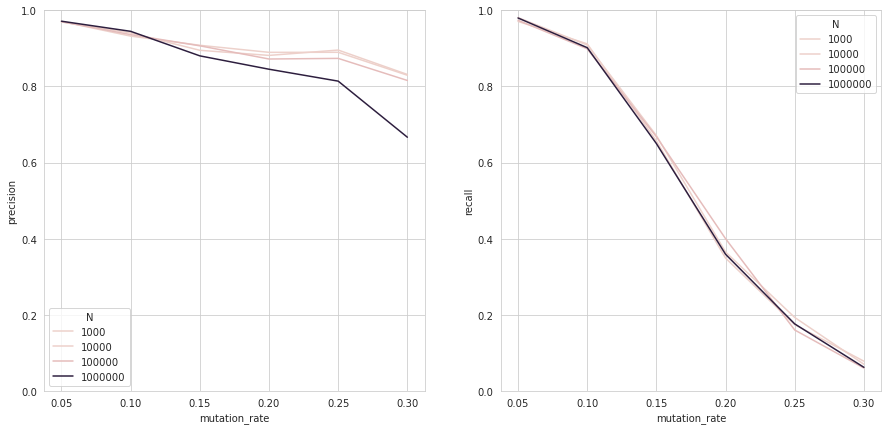

In [48]:
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame(results)
fig,axes = plt.subplots(1,2,figsize=(15,7))
for y,ax in zip(['precision', 'recall'],axes):
    sns.set_style("whitegrid")
    sns.lineplot(ax=ax,data=df,y=y,x='mutation_rate', hue='N', style='tuple_length')
    ax.set_ylim(0,1)


plt.grid(True)

In [29]:
hits = np.array([0 for _ in range(num_paths)])
tp = np.array([0 for _ in range(num_paths)])
recall = np.array([0 for _ in range(num_paths)])
paths = generate_paths(seq, path_len, num_paths, k, 0.2, alphabet)
dists = np.array([0 for _ in range(num_paths)])

for i,path in tqdm(enumerate(paths),total=len(paths)):
    path = paths[i]
    reference, query, node_path = path
    query_mmers = [query[j:j+m] for j in range(len(query) - m + 1)]
    query_mmer_sketches = get_discrete_mmer_sketches(query_mmers, len(query), m, alphabet, G, sketcher)
    query_sketches = get_kmer_sketches(query_mmer_sketches, len(query), k, m, stride, embed_dim2,stride2=1)

    for qi,query_sketch in enumerate(query_sketches):
        if query_sketch in lut:
            for node in lut[query_sketch]: # for each node j in the matches
                hits[i] += 1
                for j in range(-3,4):
                    qj = qi + j
                    d1 = editdistance.eval(reference[:(node-node_path[0])], query[:qj])
                    d2 = editdistance.eval(reference[(node-node_path[0]):], query[qj:])
                    d = editdistance.eval(reference, query)
                    dists[i] = d1+d2 - d
                    if(  d1+d2 <= d + recall_distance):
                        tp[i] += 1
                        recall[i] = 1
                        break
print(np.unique(dists,return_counts=True))               
np.mean(recall), np.sum(tp) / np.sum(hits)

100%|██████████| 1000/1000 [00:07<00:00, 139.11it/s]

(array([  0,   1,  26,  70,  86,  88, 136, 176, 202, 222, 263, 266, 278,
       334, 348]), array([899,  88,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1]))


(0.434, 0.9703315881326352)

In [50]:
times = []
sketcher = TS(t=tuple_length, D=embed_dim, A=len(alphabet))    
# sketcher = DTS(t=tuple_length, D=embed_dim, D2=embed_dim2, A=len(alphabet))    

for N in [1000000, 2000000,5000000, 10000000]:
    seqv = np.random.choice(alphabet, N)
    seq = ''.join(seqv)
    mmers = [seqv[i:i+m] for i in range(N - m + 1)]
    start = time.time()
    mmer_sketches = get_discrete_mmer_sketches(mmers, N, m, alphabet, G, sketcher)
    end = time.time()
    print(f'{N}: {end-start}')
    times.append(end-start)


1000000: 12.36048674583435
2000000: 24.3324134349823
5000000: 61.178688764572144
10000000: 121.78581070899963


In [ ]:
seqv = np.random.choice(alphabet, N)
seq = ''.join(seqv)
sketcher = DTS(t=tuple_length, D=embed_dim, D2=embed_dim2, A=len(alphabet))    

# Change this to use TSS!
mmers = [seqv[i:i+m] for i in range(N - m + 1)]
mmer_sketches = get_discrete_mmer_sketches(mmers, N, m, alphabet, G, sketcher)
sketches = get_kmer_sketches(mmer_sketches, N, k, m, stride, embed_dim2,stride2)